#实验5.1

In [6]:
import numpy as np
import torch as nn
import os
from PIL import Image
import matplotlib.pyplot as plt

['ambulance', 'apple', 'bear', 'bicycle', 'bird', 'bus', 'cat', 'foot', 'owl', 'pig']
共有十类，每类随机取得十张图片如下：


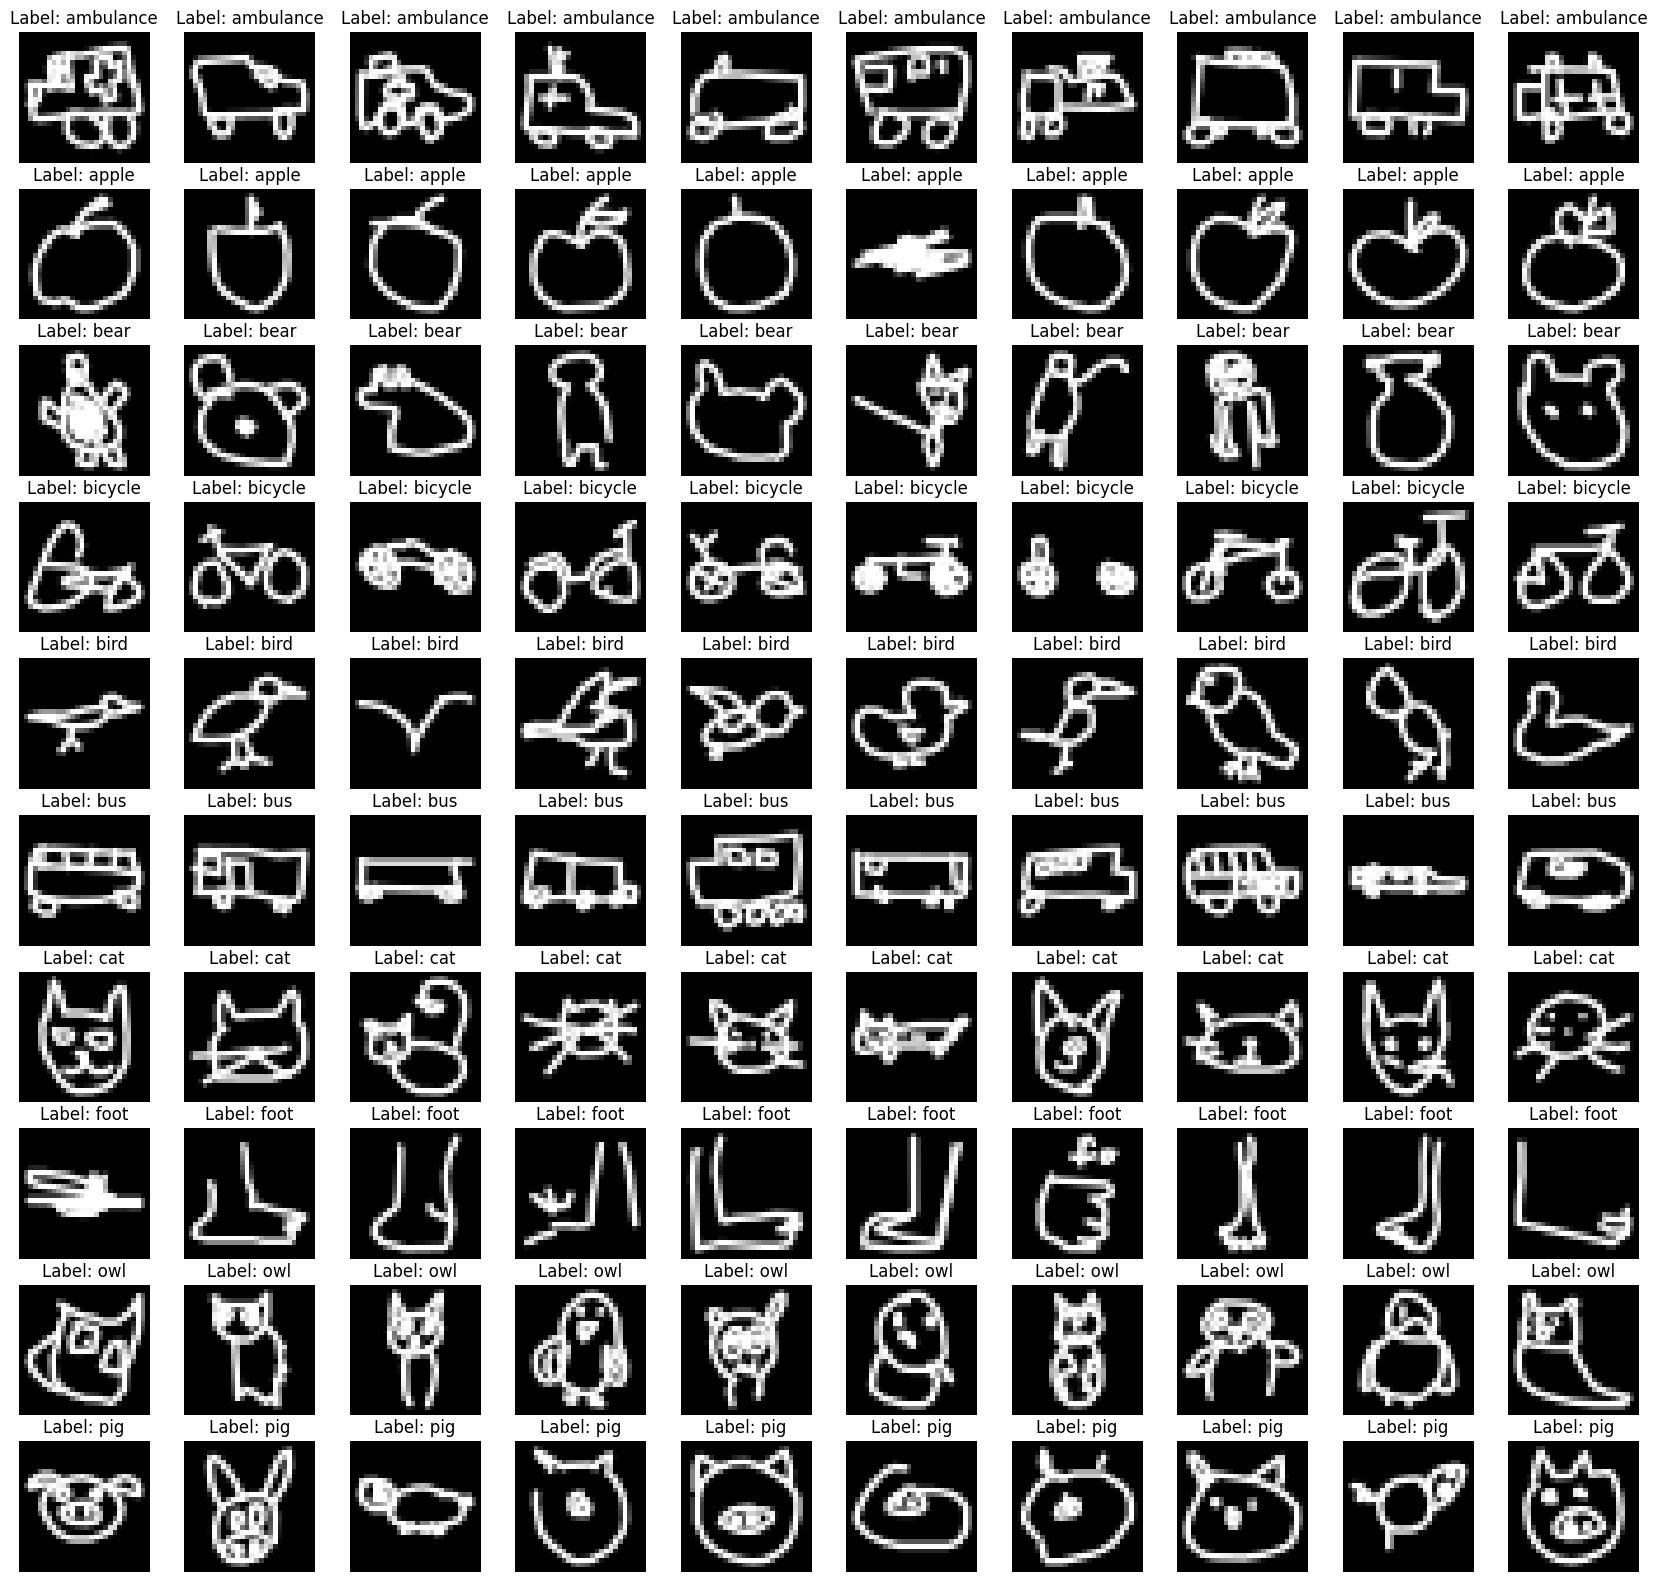

In [7]:
#任务1，数据读取并且每类展示10张图片
data_dir='quick_draw_data'
listes=os.listdir(data_dir)
print(listes)
data={}

for i in range(len(listes)):
    data[listes[i]]=(np.load(data_dir+'/'+listes[i]+'/'+listes[i]+'.npy'))


random_array = np.random.randint(0, data[listes[0]].shape[0], size=20)
fig, ax = plt.subplots(10, 10, figsize=(21, 20))

print("共有十类，每类随机取得十张图片如下：")
# for j in range(10):
for j in range(len(listes)):
    for i in range(10):
        ax[j][i].set_title(f"Label: {listes[j]}")
        ax[j][i].imshow(data[listes[j]][random_array[i]].reshape(28, 28), cmap='gray')
        ax[j][i].axis('off')
plt.show()

# print(data['apple'].shape)

#数据集划分

In [9]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelBinarizer


#目前数据全部放在Data中，并且是一个字典的形式，在这里需要给上标签
label=[]
for i,name in enumerate(data.keys()):
    label.append(np.full((len(data[name]),),i))
labels=np.concatenate(label)

new_data=np.concatenate(list(data.values()))


# 划分训练集和验证集,按照标签均匀分出这些测试集和训练集
X_train, X_other, y_train, y_other = train_test_split(new_data,labels,test_size=0.4,
stratify=labels,shuffle=True,random_state=42)

x_test, x_verify, y_test, y_verify = train_test_split(X_other, y_other, test_size=0.25)

# 归一化和重新整形
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0
x_verify = x_verify.reshape(-1, 28, 28, 1) / 255.0
y_verify = torch.tensor(y_verify)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# 将 NumPy 数组转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
x_verify = torch.tensor(x_verify, dtype=torch.float32)

# 将标签转换成 one-hot 编码
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
y_val = encoder.fit_transform(y_verify)

y_train = torch.as_tensor(y_train,dtype=torch.float32)
y_val = torch.as_tensor(y_val,dtype=torch.float32)
y_test = torch.as_tensor(y_test,dtype=torch.float32)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = X_train.to(device)
x_test = x_test.to(device)
x_verify = x_verify.to(device)
y_verify = y_val.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

#定义模型

In [11]:
import torch.nn as nn
# 构建CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x= self.pool2(x)
        x=nn.Flatten()(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)
# 编译模型
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:

def train(model,num_epochs,batch_size,X_train,y_train,x_val,y_val):
    # 训练模型
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        model.train()
        indices = np.random.randint(0, len(X_train), batch_size)
        X_train2 = X_train[indices].to(torch.device('cuda:0'))
        y_train2 = y_train[indices].argmax(axis=1).to(torch.device('cuda:0'))
        x = torch.transpose(X_train2, 3, 2)  # 将通道维度移动到最后
        x = torch.transpose(x, 2, 1)  # 将宽度维度移动到通道维度后面
        y_hat = model(x)
        loss = criterion(y_hat, y_train2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch+1)%10 == 0:
            train_loss += loss.item()
            train_acc += (y_hat.argmax(axis=1) == y_train2).sum().item()
            train_acc /= len(X_train2)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
    # 验证模型
        val_loss, val_acc = 0.0, 0.0
        if(epoch+1)%10 == 0:
            model.eval()
            with torch.no_grad():
                indices2 = np.random.randint(0, len(x_val), 1000)
                inputs = x_val[indices2].to(torch.device('cuda:0'))
                x = torch.transpose(inputs, 3, 2)  # 将通道维度移动到最后
                x = torch.transpose(x, 2, 1)
                targets = y_val[indices2].argmax(axis=1).to(torch.device('cuda:0'))
                outputs = model(x)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * len(inputs)
                val_acc += (outputs.argmax(axis=1) == targets).sum().item()
            val_loss /= 1000
            val_acc /= 1000
            val_losses.append(val_loss)
            val_accs.append(val_acc)

             # 展示训练进度
            print("Epoch [{}/{}] train_loss: {:.4f} train_acc: {:.4f} val_loss: {:.4f} val_acc: {:.4f}".format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
    return train_losses,val_accs

In [13]:
train_losses,val_accs=train(model,2000,200,X_train,y_train,x_test,y_test)

Epoch [10/2000] train_loss: 2.1076 train_acc: 0.2850 val_loss: 2.0225 val_acc: 0.4140
Epoch [20/2000] train_loss: 1.6416 train_acc: 0.4850 val_loss: 1.6879 val_acc: 0.5040
Epoch [30/2000] train_loss: 1.4681 train_acc: 0.5250 val_loss: 1.3981 val_acc: 0.5460
Epoch [40/2000] train_loss: 1.2764 train_acc: 0.5700 val_loss: 1.3176 val_acc: 0.5550
Epoch [50/2000] train_loss: 1.3247 train_acc: 0.5650 val_loss: 1.1790 val_acc: 0.6030
Epoch [60/2000] train_loss: 1.0070 train_acc: 0.6550 val_loss: 1.1467 val_acc: 0.6060
Epoch [70/2000] train_loss: 0.9981 train_acc: 0.6400 val_loss: 1.0315 val_acc: 0.6430
Epoch [80/2000] train_loss: 1.1323 train_acc: 0.6400 val_loss: 0.9364 val_acc: 0.6940
Epoch [90/2000] train_loss: 1.0077 train_acc: 0.6900 val_loss: 0.9782 val_acc: 0.6720
Epoch [100/2000] train_loss: 0.8601 train_acc: 0.7150 val_loss: 0.8651 val_acc: 0.7220
Epoch [110/2000] train_loss: 0.9943 train_acc: 0.6850 val_loss: 0.9624 val_acc: 0.6890
Epoch [120/2000] train_loss: 0.9819 train_acc: 0.680

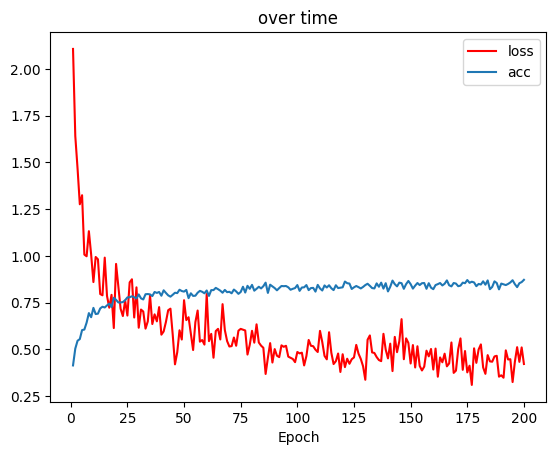

In [14]:
# 绘制Loss曲线
plt.plot(range(1, len(train_losses) + 1), train_losses,color='red',label='loss')
plt.plot(range(1, len(val_accs) + 1), val_accs,label='acc')

plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.title('over time')
plt.show()
# 绘制Accuracy曲线

In [34]:
import torch.nn as nn
#用于计算和验证
def evalute(model, x_test):
    model.eval()
    input = x_test.to(torch.device('cuda:0'))
    x = torch.transpose(input, 3, 2)  # 将通道维度移动到最后
    x = torch.transpose(x, 2, 1)  # 将宽度维度移动到通道维度后面
    y_hat = model(x)
    return y_hat.argmax(axis=1)

#用于计算和验证
def evalute2(model, x_test):
    model.eval()
    input = x_test.to(torch.device('cuda:0'))
    x = torch.transpose(input, 3, 2)  # 将通道维度移动到最后
    x = torch.transpose(x, 2, 1)  # 将宽度维度移动到通道维度后面
    y_hat = model(x)
    y_hat=nn.functional.softmax(y_hat,dim=1)
    return y_hat


共有十类，每类随机预测十张图片如下，红色标注为预测错误，黑色为预测正确：


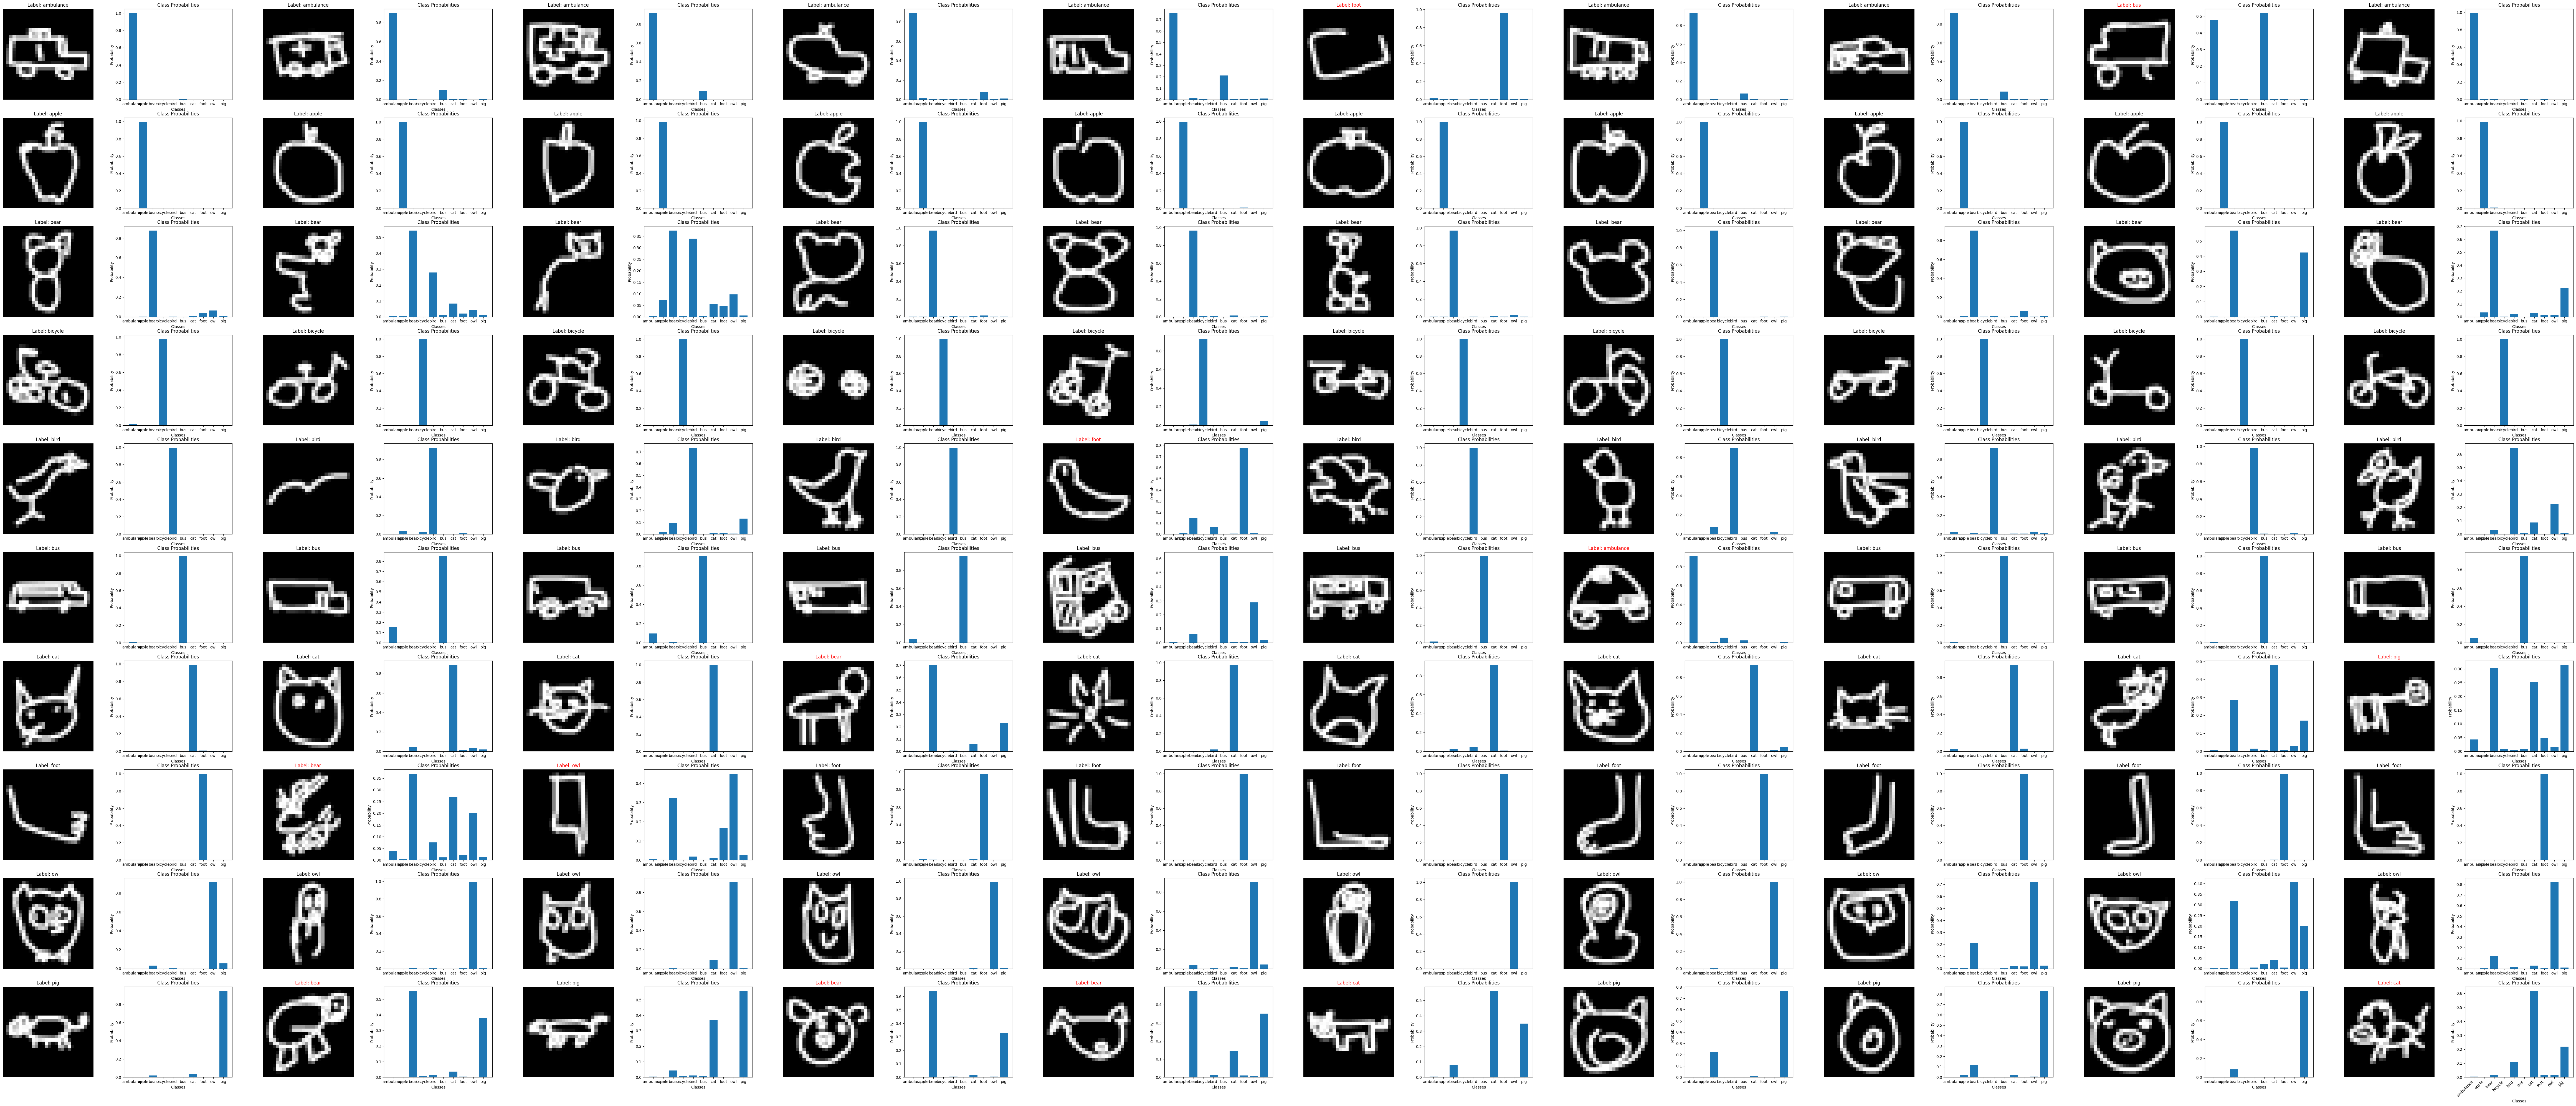

In [37]:
# 绘制图表
random_array = np.random.randint(0, 200, size=10)
fig, ax = plt.subplots(10, 20, figsize=(120, 50))
print("共有十类，每类随机预测十张图片如下，红色标注为预测错误，黑色为预测正确：")
# for j in range(10):
for j in range(10):
    data1 = new_data[random_array + 20000 * j].reshape(-1, 28, 28, 1) / 255.0
    data1 = torch.tensor(data1, dtype=torch.float32)
    out = evalute(model, data1).cpu().numpy()
    out2 = evalute2(model, data1).cpu().detach().numpy()

    for i in range(10):
        ax[j][i*2].set_title(f"Label: {listes[j]}")
        ax[j][i*2].imshow(data[listes[j]][random_array[i]].reshape(28, 28), cmap='gray')
        ax[j][i*2].axis('off')
        if (out[i] != j):
            colors = 'red'
        else:
            colors = 'black'
        ax[j][i*2].axis('off')
        ax[j][i*2].set_title(f"Label: {listes[out[i]]}", color=colors)

        ax[j][i*2+1].bar(labels, out2[i])
        ax[j][i*2+1].set_title('Class Probabilities')
        ax[j][i*2+1].set_xlabel('Classes')
        ax[j][i*2+1].set_ylabel('Probability')
        plt.xticks(rotation=45, ha='right')

# 显示图表
plt.show()

#实验5.2

In [2]:
#使用Rnn对模型进行训练
import numpy as np
import torch as nn
import os
from PIL import Image
import matplotlib.pyplot as plt

#在此处读取数据

['ambulance', 'apple', 'bear', 'bicycle', 'bird', 'bus', 'cat', 'foot', 'owl', 'pig']
共有十类，每类取得十张图片如下：


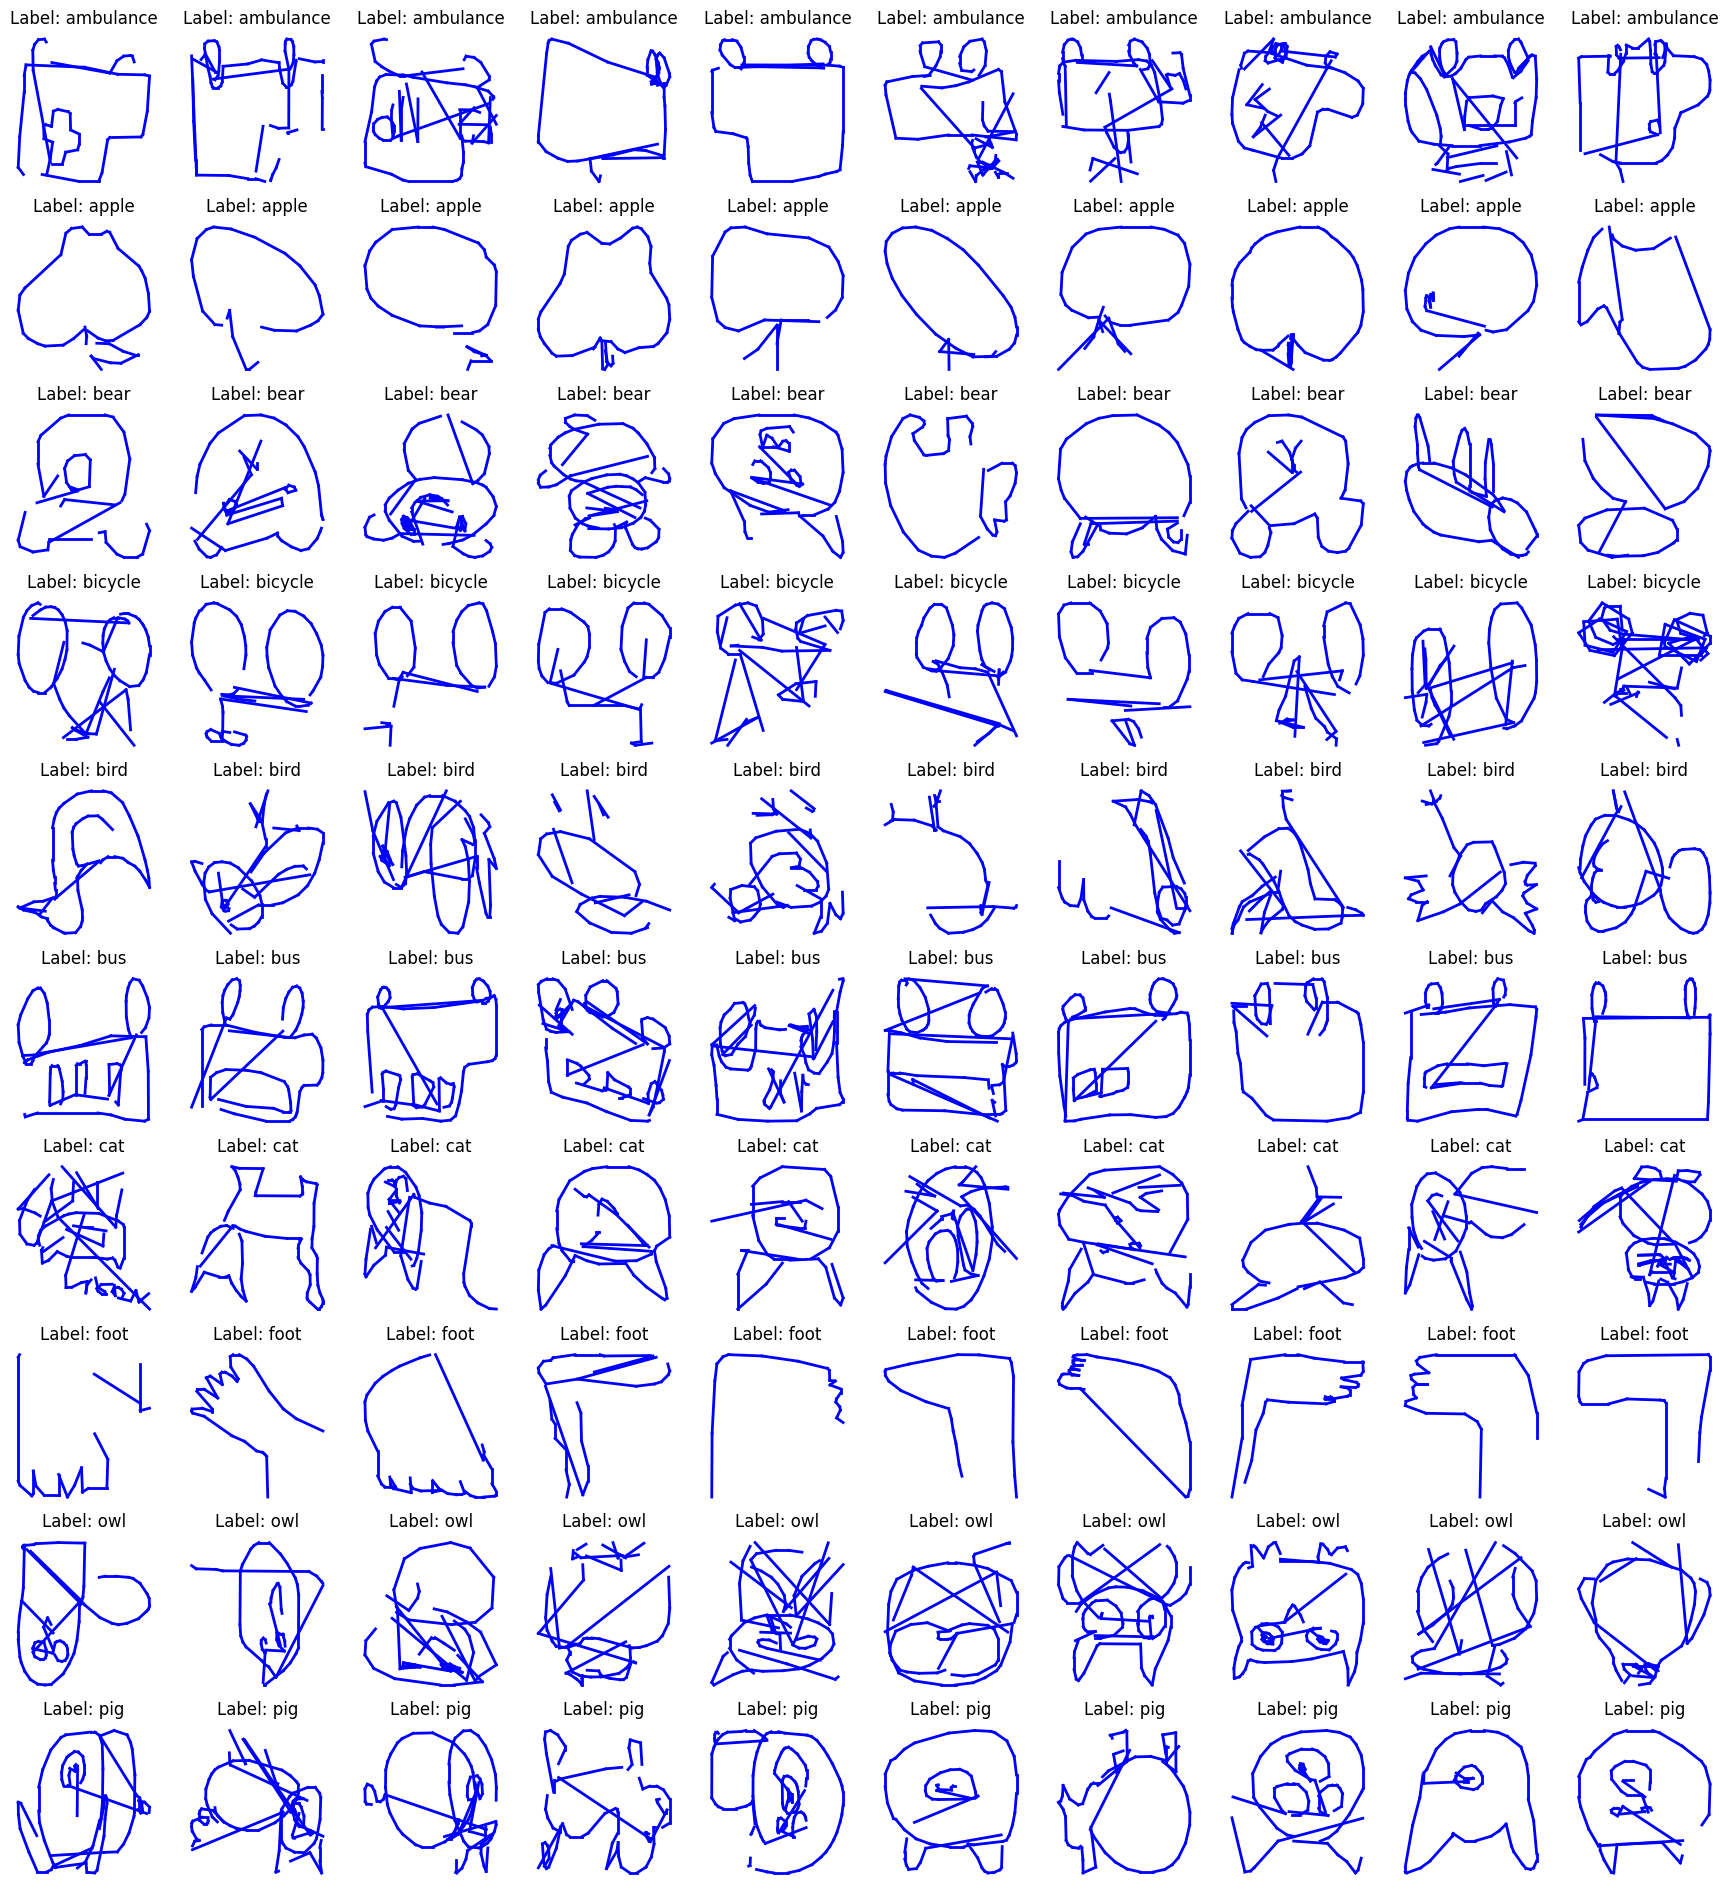

In [59]:
#任务1，数据读取并且每类展示10张图片
data_dir='sketch_datas'
listes=os.listdir(data_dir)
for i in range(len(listes)):
    listes[i]=listes[i][:-4]
data={}
print(listes)

for i in range(len(listes)):
    data[listes[i]]=(np.load(data_dir+'/'+listes[i]+'.npy'))

# 绘制图表
fig, ax = plt.subplots(10, 10, figsize=(22, 24))
print("共有十类，每类取得十张图片如下：")
# for j in range(10):
for j in range(10):
    for i in range(10):
        x=0
        y=0
        for dx, dy, p1, p2, p3 in data[listes[j]][i]:
            if p1 == 1:
       # 绘制直线
                ax[j][i].plot([x, x+dx], [y, y+dy], 'b-', linewidth=2)
            if p2 == 1:
        # 绘制点
                pass
    # plt.plot(x+dx, y+dy, 'ro', markersize=10)
            if p3 == 1:
                break
            x += dx
            y += dy
        ax[j][i].axis('off')
        ax[j][i].set_title(f"Label: {listes[j]}")

# 显示图表
plt.show()


In [60]:
from torch import device
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelBinarizer

#在这里进行测试包括输入形状等等
long=[]
for i in listes:
    long.append(data[i].shape[1])
maxlength=max(long)

#填充各个数据集，到特征为151 5, 为止
import numpy as np
new_row = np.array([0, 0, 0, 0, 1])
t=0
for j in listes:
    for i in range(maxlength-long[t]):
        data[j] = np.concatenate([data[j], np.tile(np.expand_dims(new_row, axis=0), (data[j].shape[0], 1, 1))], axis=1)
    t+=1

#转换成样本和标签，样本为new_data,标签为label
label=[]
for i,name in enumerate(data.keys()):
    label.append(np.full((len(data[name]),),i))
labels=np.concatenate(label)

new_data=np.concatenate(list(data.values()))

# #划分测试集、训练集、验证集
from sklearn.model_selection import train_test_split

X_train1, X_other1, y_train1, y_other1 = train_test_split(new_data,labels,test_size=0.4,
stratify=labels,shuffle=True,random_state=42)
x_verify1,x_test1,y_verify1,y_test1 = train_test_split(X_other1, y_other1, test_size=0.25)

# 将数据集转换成 Tensor 格式
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1)

X_val1 = torch.tensor(x_verify1, dtype=torch.float32)
y_val1 = torch.tensor(y_verify1)

X_test1 = torch.tensor(x_test1, dtype=torch.float32)
y_test1 = torch.tensor(y_test1)

# 将标签转换成 one-hot 编码
encoder = LabelBinarizer()
y_train1 = encoder.fit_transform(y_train1)
y_test1 = encoder.fit_transform(y_test1)
y_val1 = encoder.fit_transform(y_val1)

y_train1 = torch.as_tensor(y_train1,dtype=torch.float32)
y_val1 = torch.as_tensor(y_val1,dtype=torch.float32)
y_test1 = torch.as_tensor(y_test1,dtype=torch.float32)

#构建模型

In [61]:
class MyModel(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(MyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        h = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).requires_grad_().to(device)
        c = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).requires_grad_().to(device)
        x, _ = self.lstm(x,(h,c))
        x = self.fc(x[:, -1, :])
        return x

def train(model,num_epochs,batch_size,X_train,y_train,x_val,y_val):
    # 训练模型
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        model.train()
        indices = np.random.randint(0, len(X_train), batch_size)
        X_train2 = X_train[indices].to(torch.device('cuda:0'))
        y_train2 = y_train[indices].argmax(axis=1).to(torch.device('cuda:0'))
        y_hat = model(X_train2)
        loss = criterion(y_hat, y_train2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch+1)%10 == 0:
            train_loss += loss.item()
            train_acc += (y_hat.argmax(axis=1) == y_train2).sum().item()
            train_acc /= len(X_train2)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            print("Epoch [{}/{}] train_loss: {:.4f} train_acc: {:.4f} ".format(epoch+1, num_epochs, train_loss, train_acc))

    # 验证模型
        val_loss, val_acc = 0.0, 0.0
        if(epoch+1)%10 == 0:
            model.eval()
            with torch.no_grad():
                indices2 = np.random.randint(0, len(x_val), 1000)
                inputs = x_val[indices2].to(torch.device('cuda:0'))
                targets = y_val[indices2].argmax(axis=1).to(torch.device('cuda:0'))
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * len(inputs)
                val_acc += (outputs.argmax(axis=1) == targets).sum().item()
            val_loss /= 1000
            val_acc /= 1000
            val_losses.append(val_loss)
            val_accs.append(val_acc)

             # 展示训练进度
            print("Epoch [{}/{}] train_loss: {:.4f} train_acc: {:.4f} val_loss: {:.4f} val_acc: {:.4f}".format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
    return train_losses,val_accs


device = torch.device('cuda:0')
learning_rate = 0.001
model = MyModel(5,258,1,10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
train_losses,val_accs=train(model,5000,200,X_train1,y_train1,X_val1,y_val1)

Epoch [10/5000] train_loss: 2.3050 train_acc: 0.0900 
Epoch [10/5000] train_loss: 2.3050 train_acc: 0.0900 val_loss: 2.3077 val_acc: 0.0840
Epoch [20/5000] train_loss: 2.3003 train_acc: 0.1250 
Epoch [20/5000] train_loss: 2.3003 train_acc: 0.1250 val_loss: 2.3041 val_acc: 0.1050
Epoch [30/5000] train_loss: 2.3017 train_acc: 0.0950 
Epoch [30/5000] train_loss: 2.3017 train_acc: 0.0950 val_loss: 2.3022 val_acc: 0.1160
Epoch [40/5000] train_loss: 2.3046 train_acc: 0.0900 
Epoch [40/5000] train_loss: 2.3046 train_acc: 0.0900 val_loss: 2.3032 val_acc: 0.1000
Epoch [50/5000] train_loss: 2.6089 train_acc: 0.1300 
Epoch [50/5000] train_loss: 2.6089 train_acc: 0.1300 val_loss: 2.5251 val_acc: 0.1140
Epoch [60/5000] train_loss: 2.3002 train_acc: 0.1300 
Epoch [60/5000] train_loss: 2.3002 train_acc: 0.1300 val_loss: 2.3054 val_acc: 0.1020
Epoch [70/5000] train_loss: 2.3006 train_acc: 0.1300 
Epoch [70/5000] train_loss: 2.3006 train_acc: 0.1300 val_loss: 2.3031 val_acc: 0.0910
Epoch [80/5000] trai

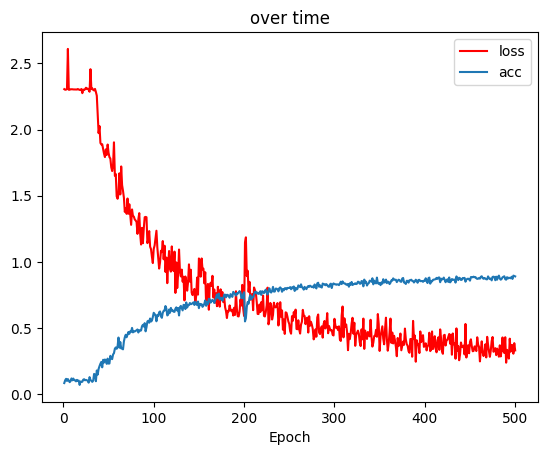

In [64]:
# 绘制Loss曲线
plt.plot(range(1, len(train_losses) + 1), train_losses,color='red',label='loss')
plt.plot(range(1, len(val_accs) + 1), val_accs,label='acc')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.title('over time')
plt.show()
# 绘制Accuracy曲线


In [65]:
def evalute(model,x_test):
    model.eval()
    input=x_test.to(torch.device('cuda:0'))
    out=model(input)
    return out.argmax(axis=1)

共有十类，每类随机预测十张图片如下，红色标注为预测错误，黑色为预测正确：


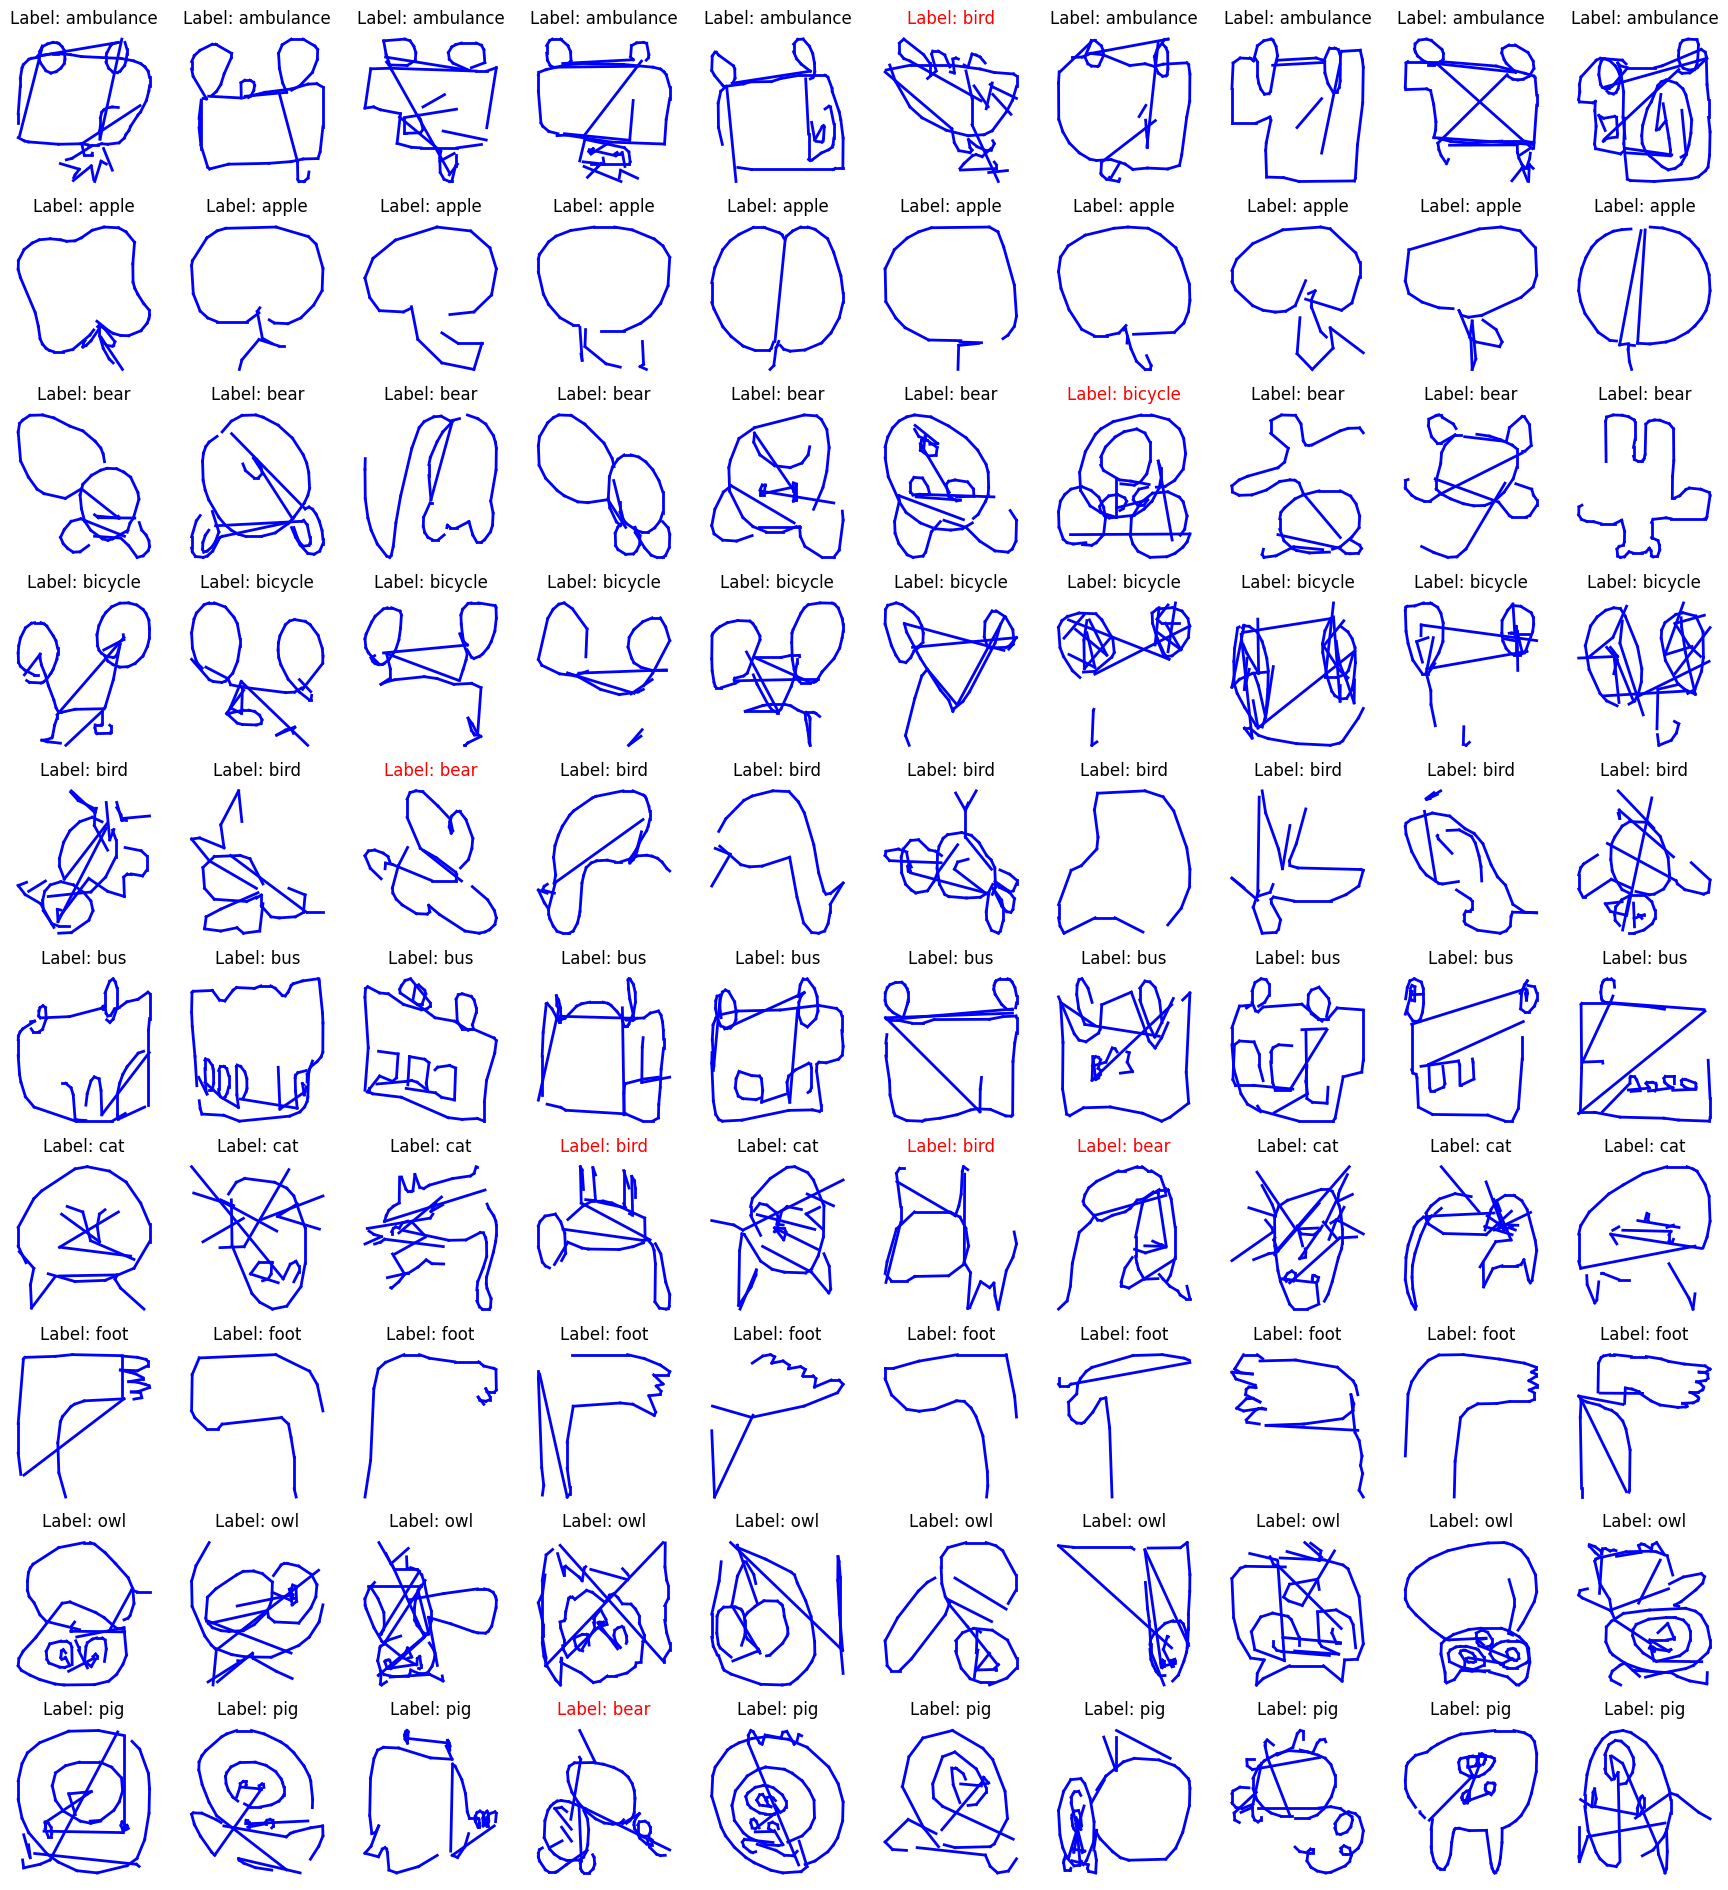

In [66]:
# 绘制图表
random_array = np.random.randint(0, 70000, size=10)
fig, ax = plt.subplots(10, 10, figsize=(22, 24))
print("共有十类，每类随机预测十张图片如下，红色标注为预测错误，黑色为预测正确：")
# for j in range(10):
for j in range(10):
    x_train=torch.tensor(new_data[random_array+70000*j],dtype=torch.float32)
    out=evalute(model,x_train).cpu().numpy()

    for i in range(10):
        x=0
        y=0
        for dx, dy, p1, p2, p3 in new_data[random_array[i]+70000*j]:
            if p1 == 1:
       # 绘制直线
                ax[j][i].plot([x, x+dx], [y, y+dy], 'b-', linewidth=2)
            if p2 == 1:
        # 绘制点
                pass
    # plt.plot(x+dx, y+dy, 'ro', markersize=10)
            if p3 == 1:
                break
            x += dx
            y += dy
        if(out[i]!=j):
            colors='red'
        else:
            colors='black'
        ax[j][i].axis('off')
        ax[j][i].set_title(f"Label: {listes[out[i]]}",color=colors)

# 显示图表
plt.show()